In [6]:
!pip list | grep Pillow

Pillow            9.3.0


768 1024 <class 'list'>
0 0 0 57 1A 2B FC 0 0 FD FB F4 6B C8 C7 B6 74 E 13 7 B 77 89 99 73 5 8 68 C0 BC FE C3 A6 88 0 2 15 53 20 34 9 F 2C 15 20 AC 3 4 DB EA EF 2A 23 28 4F 26 32 3 2 1 D3 1 1 2 0 0 0 0 0 51 7 F CF D7 D5 3B 13 1A 35 46 4B 1D 66 25 72 2D 44 88 98 A5 56 64 6D 4D 87 8A FC DB 24 94 A6 B6 85 C8 C9 A 1 1 AD B2 B4 70 53 70 58 A6 A7 2E 31 37 66 27 3B 1 1 1 92 65 53 B4 C7 CD C0 7C F 17 43 7F 58 11 1F 71 D4 D9 EA D4 47 65 13 1E 1 1 1 60 BB BC 67 47 32 FF E9 27 34 3B 42 5D 72 78 56 47 52 8F 58 E B3 F8 F6 3E 75 7B 3E 64 65 FD D1 B2 1F 1B 25 68 7B 88 40 51 5B 97 75 2E DE F8 F4 58 96 97 F4 BD A3 F0 EE E8 38 F9 FE 4D 57 60 17 4F 93 EB E6 DE E2 91 77 A1 66 10 A8 70 5E 5B B2 B7 8C D6 D5 CC C8 C4 12 44 18 4B 3B 44 A9 A6 A3 A7 8B 35 6E 40 D 7B A8 AF 5B 36 38 7C 4E 49 82 4C F 21 74 29 81 82 7F C1 C1 BC E8 9A 81 A7 7A 37 2F 5C 64 C4 8B 3A E6 9A C6 71 DD E7 90 91 8D D0 AF 22 90 11 17 46 2B F 75 65 81 16 61 A5 56 34 14 91 E1 DF DC BB 1F 6B 98 9C E4 C3 1E C6 7B 66 A8 B9 C6 C9 9E 31 78 17 22 AA

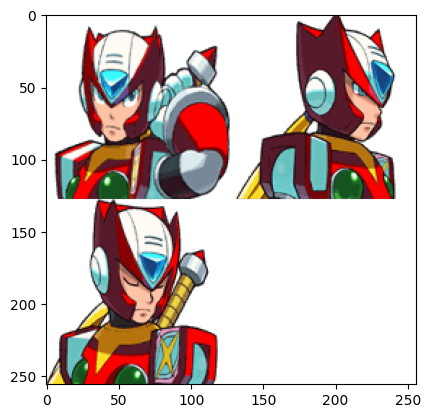

In [80]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

zero_im = Image.open('zero.png').convert('P', dither=Image.Dither.NONE, palette=Image.Palette.ADAPTIVE, colors=256)


plt.imshow(zero_im)

print(len(zero_im.getpalette('RGB')), len(zero_im.getpalette('RGBA')), type(zero_im.getpalette()))

' '.join([f'{h:02X}' for h in zero_im.getpalette()])

print(' '.join([f'{h:X}' for h in zero_im.getpalette(rawmode='RGB')]))
print()
print(' '.join([f'{h:X}' for h in zero_im.getpalette(rawmode='RGBA')]))

pal = zero_im.getpalette('RGBA')

arr = np.array(zero_im.getpalette('RGBA'))
print(arr[687:])
print(np.sum(arr[687:]==0))

init RGBA ()


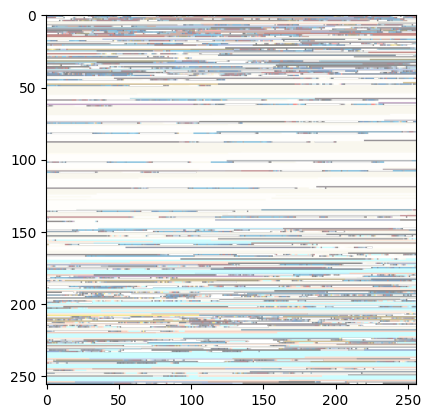

In [291]:
import joblib
import itertools
import struct
import statistics as st
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile, TgaImagePlugin, ImagePalette
from core.io_util import FileStream

ImageFile.LOAD_TRUNCATED_IMAGES = True

def min_max(im):
    return (im - im.min()) / im.max()

class OOPImageFile(ImageFile.ImageFile):
    format = 'OOP'
    format_description = ''

    @staticmethod
    def accept(prefix):
        return prefix[:3] == b"OOP"

    def _open(self):
        self._size = (256, 256)
        self.mode = 'RGBA'
        self.decoder = 'OOP'

        self.fp.read(7) # TODO: TEMPORARY FOR JOBLIB HEADER
        data_start = self.fp.tell()

        # self.fp.read(256*256)

        # self.palette = ImagePalette.raw("RGBA", self.fp.read(1024))
        # raw_mode = "P"
        # orientation = 0
        # depth = 24

        # self.fp.seek(0)
        # self.tile = [("tga_rle", (0, 0) + self.size, data_start, (raw_mode, orientation, depth))]
        # self.tile = [("raw", (0, 0) + self.size, data_start, (raw_mode, 0, orientation))]
        self.tile = [(self.decoder, (0, 0) + self.size, data_start, ())]

class OOPDecoder(ImageFile.PyDecoder):
    _pulls_fd = True

    def __init__(self, mode, *args):
        super(ImageFile.PyDecoder, self).__init__(mode, *args)
        print('init', mode, args)

    def decode(self, buffer):
        data: bytes = self.fd.read(256*256)

        palette = []
        for _ in range(256):
            r, g, b, a = struct.unpack("<4B", self.fd.read(4))
            palette.append((r, g, b, a))

    #     while idx < len(im_data):
    # next_byte = im_data[idx]
    # idx+=1

    # if next_byte&0x80:
    #     rle_packets += 1
    #     count = (next_byte & 0x7F)+1
    #     color = im_data[idx+1]
    #     counts.add(count)
    #     colors.add(color)
    #     idx += 1
    # else:
    #     raw_packets += 1
    #     count = (next_byte & 0x7F)+1
    #     counts2.add(count)
    #     for idx2 in range(1, count):
    #         color = im_data[idx+idx2]
    #         colors2.add(color)
    #     idx += count
        output = []
        idx = 0
        while idx < len(data):
            next_byte = data[idx]
            count = (next_byte & 0x7F)+1
            idx += 1

            if next_byte & 0x80: # RLE
                color_idx = data[idx+1]
                rgba = palette[color_idx]
                output.extend(rgba * count)
                idx += 1
            else: # RAW
                for offset in range(1, count):
                    color_idx = data[idx+offset]
                    rgba = palette[color_idx]
                    output.extend(rgba)
                    idx += 1
        # for val in data[::-1]:
        #     r, g, b, a = palette[val]
        #     output.extend((r, g, b, a))
        
        self.set_as_raw(bytes(output))
        return -1, 0

Image.register_decoder('OOP', OOPDecoder)
Image.register_open(OOPImageFile.format, OOPImageFile)
Image.register_extension(OOPImageFile.format, '.data')

# initial = joblib.load('figures2/initial.data')
# print([h for h in initial], len(initial))

im = Image.open('../../figures2/cockpit_file0_im0_bpp16.data')
plt.imshow(im)

# im_data = joblib.load('figures2/cockpit_file0_im1_bpp16.data')
# curr_pal = im_data[-1024:]

# # print(np.array(im))
# im2 = Image.frombytes("P", (256, 256), im_data, "raw")
# im2.putpalette(im.getpalette())

# print([h for h in im.getpalette()])
# plt.imshow(im2)

In [ ]:
print('first 10', [f'{h:X}' for h in im_data[:10]])
# zero_im = Image.open('zero.png').convert('L')
# curr_pal = im_data[-1024:]

# print([h for h in curr_pal])
# assert len(curr_pal)==1024

# im = Image.frombytes("P", (256, 256), im_data, "OOP")
# im = Image.frombytes("P", (256, 256), im_data, 'raw', 'P', 0, -1)
# im = Image.frombytes("P", (512, 448), im_data, 'raw', 'P', 0, -1)

# im.putpalette(curr_pal, 'RGBA')
# plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256)
float64 0.0 51.5823974609375 255.0 77.0470503744343
float64 0.0 47.29723612467448 255.0 77.94476497634568


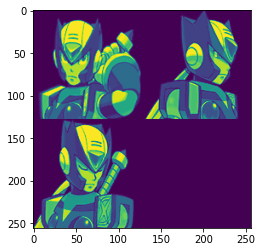

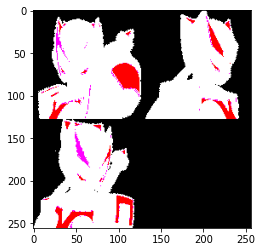

In [79]:
import joblib
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def get_xy(ar1, ar2):
    dict = {v:set() for v in range(0, 256)}
    dict2 = {}

    for row in range(ar1.shape[0]):
        for col in range(ar1.shape[1]):
            val = ar1[row, col]
            rgba = ar2[row, col]
            dict[val].add(f'{rgba}')
            dict2[val] = rgba
    X = []
    Y = []
    for key, val in dict.items():
        rgba = dict2[key]
        X.append(list(rgba))
        Y.append(key)
    return X, Y

datas = ['figures2/cockpit_file0_im1_bpp16.data']
# datas.append('figures2/2D_LOAD_SIGMA_file0_im0_bpp16.data', )

pngs = ['zero.png']
# pngs.append('sigma.png')

X = []
Y = []
for data_path, png_path in zip(datas, pngs):
    arr2 = np.array(Image.open(png_path).convert('RGB')).astype(np.float64)
    print(arr2.shape[:2][::-1])

    im_data = joblib.load(data_path)
    im = Image.frombytes("P", arr2.shape[:2][::-1], im_data, 'raw', 'P', 0, -1)
    arr1 = np.array(im.convert('L')).astype(np.float64)

    print(arr1.dtype, arr1.min(), arr1.mean(), arr1.max(), arr1.std())
    print(arr2.dtype, arr2.min(), arr2.mean(), arr2.max(), arr2.std())

    plt.figure()
    plt.imshow(arr1)

    plt.figure()
    plt.imshow(arr2)

    temp_x, temp_y = get_xy(arr1, arr2)
    X.extend(temp_x)
    Y.extend(temp_y)

In [76]:
from sklearn.linear_model import LinearRegression, Ridge
from scipy.optimize import nnls, lsq_linear
# x, res = nnls(X, Y)

reg = LinearRegression(fit_intercept=False).fit(X, Y)
print(reg.score(X, Y), reg.coef_, reg.coef_.sum(), reg.intercept_)

0.9934442237736002 [0.33190458 0.63418897 0.12925126] 1.0953448119408031 0.0


float64 0.0 51.5823974609375 255.0 77.0470503744343
uint8 0 42.112274169921875 255 65.41642284929287
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  8  7  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  5 14 50 57 50 50 57 51 19 11  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

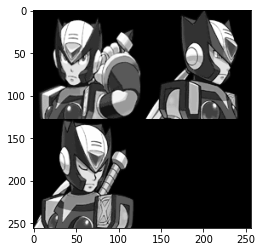

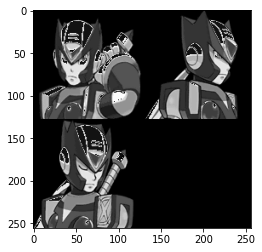

In [81]:


# arr1 = np.array(im.convert('L')).astype(np.float64)
# arr2 = np.array(zero_im.convert('RGB')).astype(np.float64)

arr2_t = arr2.copy()
arr2_t = (arr2_t[:, :, 0]*reg.coef_[0])+(arr2_t[:, :, 1]*reg.coef_[1])+(arr2_t[:, :, 2]*reg.coef_[2])
# arr2_t[arr2_t>255.0] = 255.0
arr2_t = arr2_t.astype(np.uint8)

print(arr1.dtype, arr1.min(), arr1.mean(), arr1.max(), arr1.std())
print(arr2_t.dtype, arr2_t.min(), arr2_t.mean(), arr2_t.max(), arr2_t.std())

plt.figure()
plt.imshow(arr1, cmap='gray')

plt.figure()
plt.imshow(arr2_t, cmap='gray')

idx = 5
print(arr1[idx].astype(np.uint8))
print(arr2_t[idx])

In [141]:
def pad_arr(a):
    return [f'{h:03}' for h in a.astype(np.uint8)]

np.set_printoptions(threshold=sys.maxsize, linewidth=1e20)
arr2 = np.array(Image.open(png_path).convert('RGB')).astype(np.float64)
print(arr2.shape[:2][::-1])

im_data = joblib.load(data_path)
im = Image.frombytes("P", arr2.shape[:2][::-1], im_data, 'raw', 'P', 0, -1)
arr1 = np.array(im.convert('L')).astype(np.float64)

arr_luma = (arr2/255.0)
print(arr_luma.shape, arr_luma.dtype, arr_luma.min(), arr_luma.max())
arr_luma = (arr_luma[:, :, 0]*.299)+(arr_luma[:,:,1]*.587)+(arr_luma[:,:,2]*.114)
arr_luma = min_max(arr_luma)*255.0

arr_avg = np.mean(arr2, axis=2)

print(arr_luma.shape, arr_luma.dtype, arr_luma.min(), arr_luma.max())

FILE_OFFSET = arr1[5].nonzero()[0][0]
# print(type(offset), offset)

print('data', pad_arr(arr1[5, FILE_OFFSET:]))
print()

for i in range(arr2.shape[2]):
    print(f'col{i}', pad_arr(arr2[5, FILE_OFFSET:, i]))

print()
print('luma', pad_arr(arr_luma[5, FILE_OFFSET:]))

print()
print(' avg', pad_arr(arr_avg[5, FILE_OFFSET:]))

print('*'*10000)

(256, 256)
(256, 256, 3) float64 0.0 1.0
(256, 256) float64 0.0 255.0
data ['008', '007', '004', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '005', '014', '050', '057', '050', '050', '057', '051', '019', '011', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000']

col0 ['003', '001', '001', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '001', '016', '089', '093', '089', '089', '093', '125', '063', '005', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', 

In [146]:
lined_up = 0
total = 0

for rows in range(arr2.shape[0]):
    for c in range(arr2.shape[1]):
        if arr1[rows, c] > 0 and np.sum(arr2[rows,c]) > 0:
            lined_up += 1
        elif arr1[rows, c] == 0 and np.sum(arr2[rows,c]) == 0:
            lined_up += 1
        else:
            print(f'whack ({rows},{c}) | {arr1[rows,c]} | {arr2[rows,c]}')
        total += 1

print(lined_up, 'out of', total)

whack (4,204) | 2.0 | [0. 0. 0.]
whack (6,205) | 1.0 | [0. 0. 0.]
whack (8,75) | 2.0 | [0. 0. 0.]
whack (8,183) | 1.0 | [0. 0. 0.]
whack (9,173) | 2.0 | [0. 0. 0.]
whack (9,186) | 1.0 | [0. 0. 0.]
whack (10,31) | 1.0 | [0. 0. 0.]
whack (10,173) | 2.0 | [0. 0. 0.]
whack (10,207) | 2.0 | [0. 0. 0.]
whack (10,209) | 1.0 | [0. 0. 0.]
whack (10,230) | 2.0 | [0. 0. 0.]
whack (11,57) | 2.0 | [0. 0. 0.]
whack (11,58) | 1.0 | [0. 0. 0.]
whack (11,214) | 2.0 | [0. 0. 0.]
whack (12,61) | 2.0 | [0. 0. 0.]
whack (12,217) | 2.0 | [0. 0. 0.]
whack (12,227) | 2.0 | [0. 0. 0.]
whack (13,38) | 1.0 | [0. 0. 0.]
whack (14,35) | 2.0 | [0. 0. 0.]
whack (14,72) | 2.0 | [0. 0. 0.]
whack (14,79) | 1.0 | [0. 0. 0.]
whack (15,27) | 1.0 | [0. 0. 0.]
whack (15,223) | 2.0 | [0. 0. 0.]
whack (15,224) | 1.0 | [0. 0. 0.]
whack (17,232) | 1.0 | [0. 0. 0.]
whack (18,80) | 1.0 | [0. 0. 0.]
whack (18,232) | 2.0 | [0. 0. 0.]
whack (20,26) | 1.0 | [0. 0. 0.]
whack (21,26) | 2.0 | [0. 0. 0.]
whack (22,115) | 2.0 | [0. 0. 0.]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00' 44
0 0 0 0 0 0 0 0 0 0 0 4 C 1B 35 31 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'



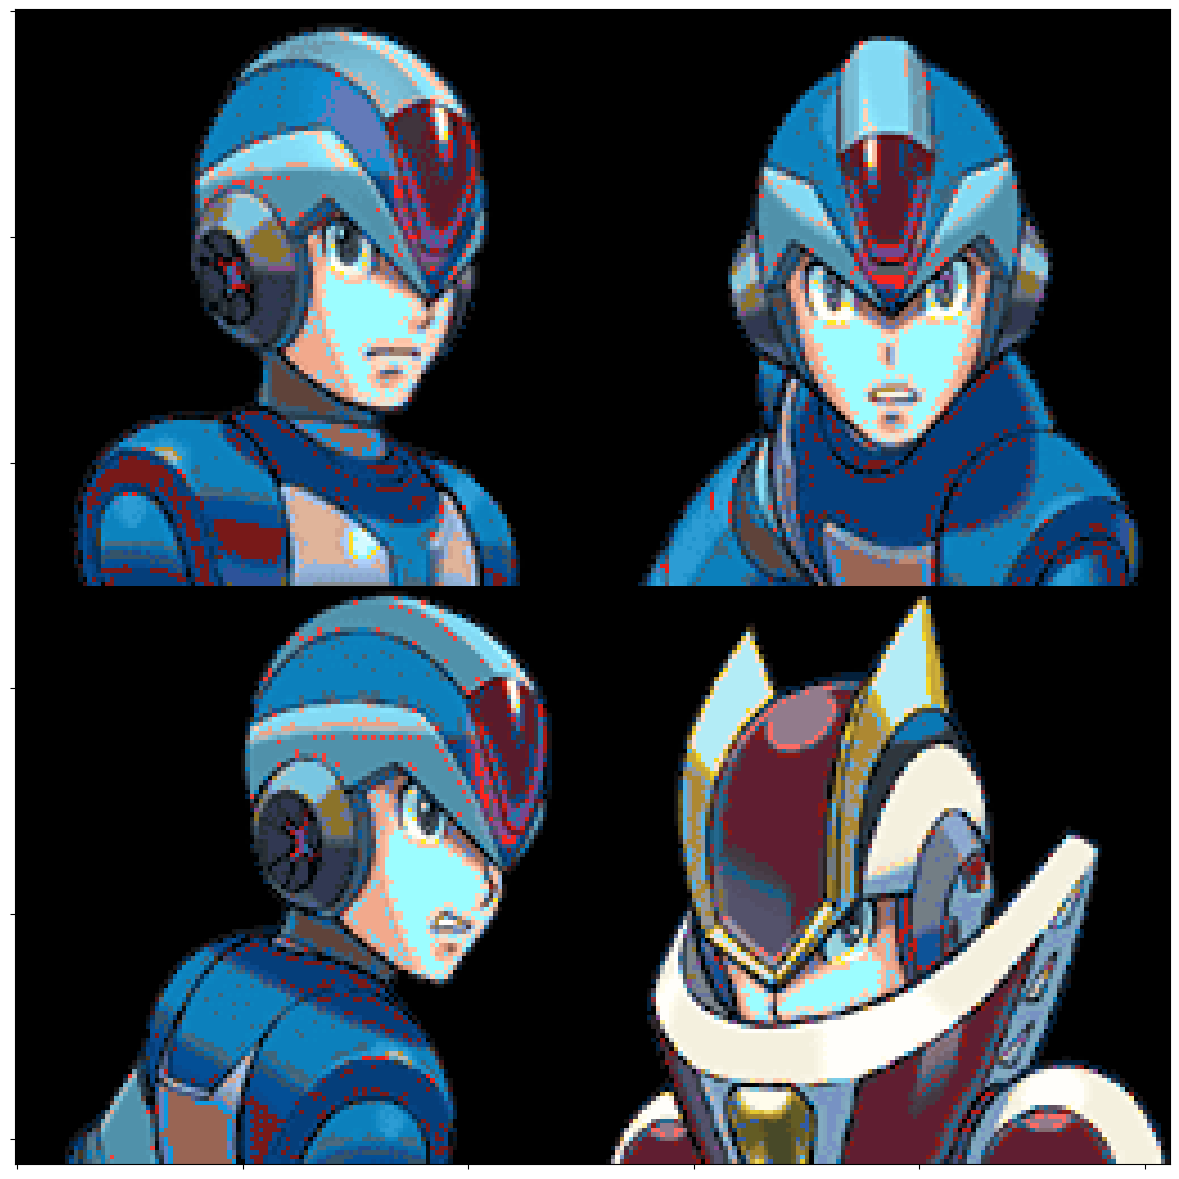

In [19]:
from core.io_util import FileStream
import matplotlib.pyplot as plt
from PIL import Image

with open('/home/jperez/data/textures/cockpit.1E3EE6FB', 'rb') as file:
# with open('/home/jperez/data/textures/2D_LOAD_SIGMA - Copy.1E3EE6FB', 'rb') as file:
    stream = FileStream(file)
    data = stream.read_remaining_bytes()


FILE_OFFSET = 1420 # 1420 (256x256), 1193824 (512x256), 1159816+4 (256x128)
cols=256
rows=256
extra_rows = 0

im_idx = 0

im_prelude = data[1376:FILE_OFFSET]
print(im_prelude, len(im_prelude))

IM_FULL_SIZE = (cols*rows)+1024
next_start = FILE_OFFSET + (im_idx * IM_FULL_SIZE)
next_end = next_start + (cols*(rows+extra_rows))

pal_start = next_start + (cols*rows)
pal_end = pal_start + 1024

# print(pal_end, 400768-pal_end)

im_data = data[next_start:next_end]
pal_data = data[pal_start:pal_end]
# pal_data = [(64*h)>>7 for h in pal_data]

im = Image.frombytes("P", (cols, rows+extra_rows), im_data, 'raw', 'P', 0, -1)
im.putpalette(pal_data, 'RGBA')
fig, curr = plt.subplots(figsize=(15, 15))
curr.set_xticklabels([])
curr.set_yticklabels([])
curr.imshow(im.convert('RGB'))

# extra = data[pal_end:pal_end+12] # b'l\x00\x01\x01temp2\x00\x00\x00'
# print(extra)

print(' '.join([f'{h:X}' for h in im_data[1024:1040]]), im_data[1024:1024+10])
print()
# print(' '.join([f'{h:X}' for h in im_data[:]]))


In [ ]:
# Mmm
print(f'repr {0x80:b} | {0x7F:b} {0b00001000 & 0x7F:b}')
print(f'header = {im_data[0]:08b} | {(im_data[0]&0x7F)+1} | {(im_data[0] & 0x80)}')

rle_packets = 0
raw_packets = 0
counts = set()
colors = set()

counts2 = set()
colors2 = set()

idx = 0
total_pixels = 0
while idx < len(im_data):
    next_byte = im_data[idx]
    count = (next_byte & 0x7F)+1
    total_pixels += count
    idx +=1

    if next_byte & 0x80:
        rle_packets += 1
        color = im_data[idx+1]
        counts.add(count)
        colors.add(color)
        idx += 1
    else:
        raw_packets += 1
        counts2.add(count)
        for idx2 in range(1, count):
            color = im_data[idx+idx2]
            colors2.add(color)
        idx += count

print(f'total={total_pixels} | diff={(256*256)-total_pixels} | 256={256*256} |  320={320*320} | 384={384*384} | 448={448*448} | 512={512*512} |')
print(f'rle={rle_packets}')
print(f'raw={raw_packets}')

In [ ]:

# def swap32(i):
#     return struct.unpack("<B", struct.pack(">B", i))[0]

# def swap32(x):
#     return (((x << 24) & 0xFF000000) |
#             ((x <<  8) & 0x00FF0000) |
#             ((x >>  8) & 0x0000FF00) |
#             ((x >> 24) & 0x000000FF))

# def swap32(x):
#     return int.from_bytes(x.to_bytes(1, byteorder='little'), byteorder='big', signed=False)

# print([f'{h:08b}' for h in im_data[:16]])
# print([f'{swap32(h):08b}' for h in im_data[:16]])